In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from mpl_toolkits import mplot3d 
import numpy as np 
import matplotlib.pyplot as plt 
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from scipy.stats import boxcox

In [2]:
def create_centered_mean(series):
    series = pd.DataFrame(series)
    centered_avg = series.rolling(window = 5)
    centered_avg = centered_avg.mean()
    return centered_avg

In [3]:
def inventory_loading():
    station_data = pd.read_csv('stations_cleaned.csv.gz')
    kmeans = pd.read_csv('kmeans_output')
    kmeans = kmeans.drop('Unnamed: 0', axis = 1)
    station_data = station_data.set_index('dock_name')
    kmeans = kmeans.set_index('start station name')
    station_data = station_data.merge(kmeans, left_index = True, right_on = 'start station name')
    station_data = station_data.reset_index()
    station_data.hour = station_data.hour.astype(str).apply(lambda x: x.zfill(2))
    station_data.loc[station_data['hour'] == '24', 'hour'] = '00'
    station_data.minute = station_data.minute.astype(str).apply(lambda x: x.zfill(2))
    station_data['time'] = station_data.hour + ':' + station_data.minute + ':' +  '00'
    station_data['datetime'] = pd.to_datetime(station_data['date'] + ' ' + station_data['time'])
    station_data = station_data.set_index(station_data['datetime'])
    return station_data

In [4]:
def data_loading():
    rider_df = pd.read_csv('downsampled_rider.csv.gz', 
                  parse_dates = ['starttime', 'stoptime', 'start_date', 'stop_date'])
    station_data = pd.read_csv('stations_cleaned.csv.gz', usecols = ['dock_id','dock_name','date','hour',
                                                                      'minute','avail_bikes','time'])

    kmeans = pd.read_csv('kmeans_output')
    kmeans = kmeans.drop('Unnamed: 0', axis = 1)
    station_data = station_data.set_index('dock_name')
    kmeans = kmeans.set_index('start station name')
    station_data = station_data.merge(kmeans, left_index = True, right_on = 'start station name')
    station_data = station_data.reset_index()
    rider_df = rider_df.set_index('starttime')
    station_data.hour = station_data.hour.astype(str).apply(lambda x: x.zfill(2))
    station_data.loc[station_data['hour'] == '24', 'hour'] = '00'
    station_data.minute = station_data.minute.astype(str).apply(lambda x: x.zfill(2))
    station_data['time'] = station_data.hour + ':' + station_data.minute + ':' +  '00'
    station_data['datetime'] = pd.to_datetime(station_data['date'] + ' ' + station_data['time'])
    station_data = station_data.set_index('datetime')
    station_data = station_data.drop(['date','hour','minute','time'], axis =1)
    non_zero = station_data[station_data['avail_bikes'] != 0].copy()
    rider_df = rider_df.groupby([pd.Grouper(freq = 'd'), 'start station id'])['stoptime'].count()
    non_zero = non_zero.groupby([pd.Grouper(freq = 'd'), 'dock_id'])['cluster'].mean()
    station_data = station_data.groupby([pd.Grouper(freq = 'd'), 'dock_id'])['cluster'].mean()
    rider_df_0 = pd.DataFrame(rider_df).merge(non_zero, left_index = True, right_on = ['datetime','dock_id']).copy()
    rider_df_0 = rider_df_0.reset_index().set_index('datetime')
    rider_df_0 = rider_df_0.reset_index().rename(columns = {'stoptime' : 'rider_demand'}).set_index('datetime')
    rider_df_0 = rider_df_0.groupby([pd.Grouper(freq = 'd'),'cluster'])['rider_demand'].sum()
    rider_df = pd.DataFrame(rider_df).merge(station_data, left_index = True, right_on = ['datetime','dock_id'])
    rider_df = rider_df.reset_index().set_index('datetime')
    rider_df = rider_df.reset_index().rename(columns = {'stoptime' : 'rider_demand'}).set_index('datetime')
    rider_df = rider_df.groupby([pd.Grouper(freq = 'd'),'cluster'])['rider_demand'].sum()

    return rider_df, rider_df_0

In [5]:
rider_df, rider_df_0 = data_loading()

/home/ubuntu/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3338: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [6]:
rider_demand_0 = pd.Series(rider_df_0[pd.IndexSlice[:,0]])

In [7]:
rider_demand_0,lam = boxcox(rider_demand_0)

In [8]:
rider_demand_0 = pd.Series(rider_demand_0)

In [9]:
true_rides_0 = pd.Series(rider_df[pd.IndexSlice[:,0]])

In [10]:
true_rides_0,lam = boxcox(true_rides_0)

In [11]:
true_rides_0 = pd.Series(true_rides_0)

In [12]:
def model_creation(df):
    X = df.values
    size = int(len(X) * 0.66)
    train, test = X[0:size], X[size:len(X)]
    history = [x for x in train]
    residuals = []
    predictions = list()
    # walk-forward validation
    for t in range(len(test)):
        demand = ARIMA(history, order=(5,1,0))
        demand_fit = demand.fit()
        output = demand_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs) 
    # evaluate forecasts
    rmse = np.sqrt(mean_squared_error(test, predictions))
    print('Test RMSE: %.3f' % rmse)
    residuals = demand_fit.resid
    residuals = pd.DataFrame(residuals)
    print(demand_fit.summary())
    print(residuals.describe())
    return demand_fit, predictions, test, residuals

In [13]:
demand_fit, predictions, test, residuals = model_creation(rider_demand_0)

Test RMSE: 78.766
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1324
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -7522.761
Date:                Sun, 20 Dec 2020   AIC                          15057.522
Time:                        19:37:34   BIC                          15088.648
Sample:                             0   HQIC                         15069.191
                               - 1324                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5064      0.024    -20.888      0.000      -0.554      -0.459
ar.L2         -0.4570      0.027    -17.243      0.000      -0.509      -0.405
ar.L3         -0.3923      0.029  

<ipython-input-14-cc883db8c0d3>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(rider_demand_0.index)


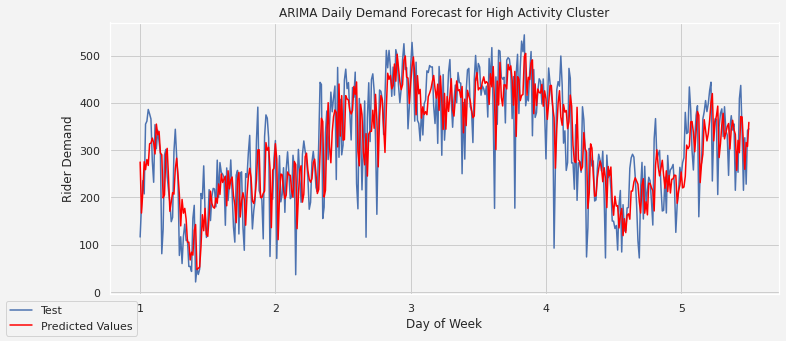

In [14]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(rider_demand_0.index)
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Rider Demand')
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Daily Demand Forecast for High Activity Cluster')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

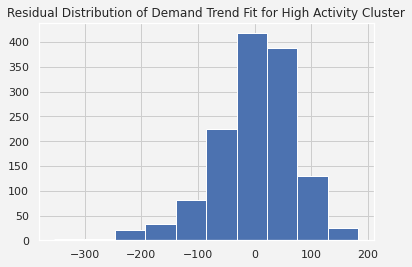

In [15]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})

plt.hist(residuals)

plt.title('Residual Distribution of Demand Trend Fit for High Activity Cluster')
plt.show

In [16]:
real_demand_fit, predictions, test, residuals = model_creation(true_rides_0)

Test RMSE: 78.086
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1324
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -7513.428
Date:                Sun, 20 Dec 2020   AIC                          15038.855
Time:                        19:38:21   BIC                          15069.981
Sample:                             0   HQIC                         15050.523
                               - 1324                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5107      0.024    -20.940      0.000      -0.559      -0.463
ar.L2         -0.4561      0.027    -17.159      0.000      -0.508      -0.404
ar.L3         -0.3938      0.029  

<ipython-input-17-fb0c31ff410a>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(true_rides_0.index)


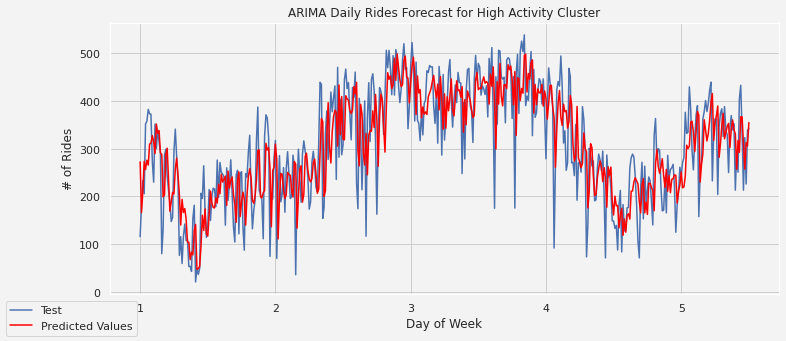

In [17]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(true_rides_0.index)
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('# of Rides')
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Daily Rides Forecast for High Activity Cluster')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

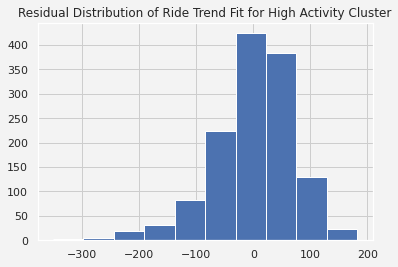

In [18]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})

plt.hist(residuals)

plt.title('Residual Distribution of Ride Trend Fit for High Activity Cluster')
plt.show

In [19]:
rider_demand_1 = pd.Series(rider_df_0[pd.IndexSlice[:,1]])

In [20]:
rider_demand_1,lam = boxcox(rider_demand_1)
rider_demand_1 = pd.Series(rider_demand_1)

In [21]:
true_rides_1 = pd.Series(rider_df[pd.IndexSlice[:,1]])

In [22]:
true_rides_1,lam = boxcox(true_rides_1)

In [23]:
true_rides_1 = pd.Series(true_rides_1)

In [24]:
demand_cluster_1_fit, predictions, test, residuals = model_creation(rider_demand_1)

Test RMSE: 4.161
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1324
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3538.210
Date:                Sun, 20 Dec 2020   AIC                           7088.421
Time:                        19:39:11   BIC                           7119.547
Sample:                             0   HQIC                          7100.089
                               - 1324                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5364      0.023    -23.617      0.000      -0.581      -0.492
ar.L2         -0.4510      0.026    -17.115      0.000      -0.503      -0.399
ar.L3         -0.3373      0.031   

<ipython-input-25-42bbe2b35f93>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(rider_demand_1.index,rotation=90)


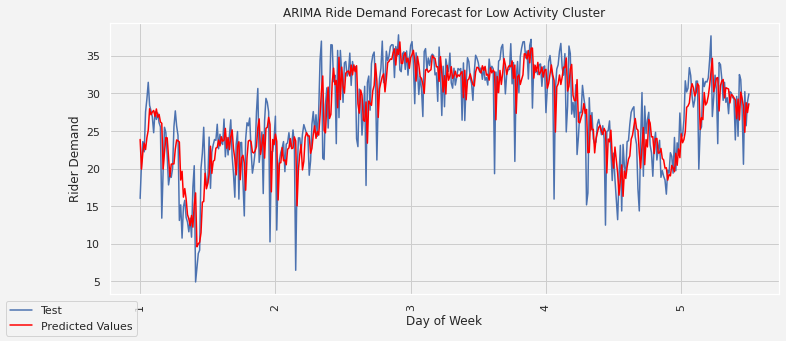

In [25]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(rider_demand_1.index,rotation=90)
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Rider Demand')
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Ride Demand Forecast for Low Activity Cluster')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

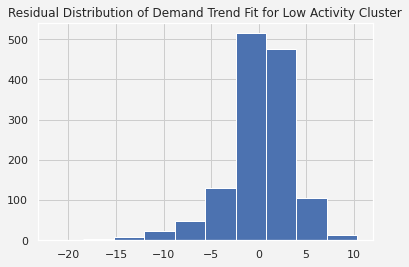

In [26]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})

plt.hist(residuals)

plt.title('Residual Distribution of Demand Trend Fit for Low Activity Cluster')
plt.show

In [27]:
true_cluster_1_fit, predictions, test, residuals = model_creation(true_rides_1)

Test RMSE: 4.143
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1324
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3532.393
Date:                Sun, 20 Dec 2020   AIC                           7076.786
Time:                        19:40:02   BIC                           7107.912
Sample:                             0   HQIC                          7088.454
                               - 1324                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5380      0.023    -23.598      0.000      -0.583      -0.493
ar.L2         -0.4504      0.026    -17.099      0.000      -0.502      -0.399
ar.L3         -0.3382      0.031   

<ipython-input-28-c87fad04ee0e>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(true_rides_1.index)


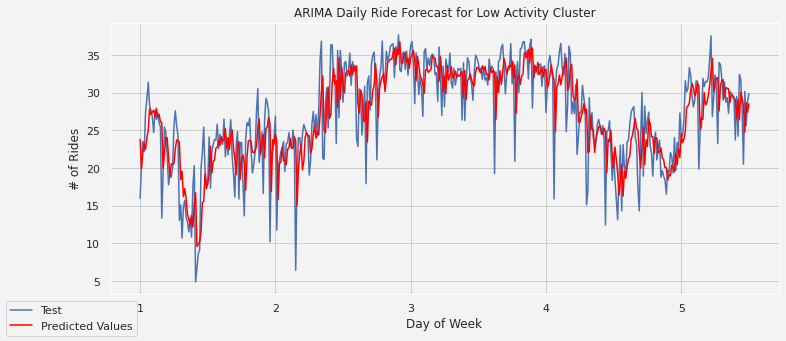

In [28]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(true_rides_1.index)
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('# of Rides')
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Daily Ride Forecast for Low Activity Cluster')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

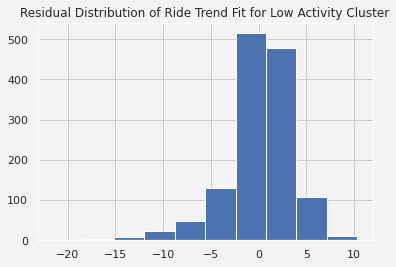

In [29]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
plt.hist(residuals)

plt.title('Residual Distribution of Ride Trend Fit for Low Activity Cluster')
plt.show

In [30]:
rider_demand_2 = pd.Series(rider_df_0[pd.IndexSlice[:,2]])

In [31]:
rider_demand_2,lam = boxcox(rider_demand_2)
rider_demand_2 = pd.Series(rider_demand_2)

In [32]:
true_rides_2 = pd.Series(rider_df[pd.IndexSlice[:,2]])

In [33]:
true_rides_2,lam = boxcox(true_rides_2)
true_rides_2 = pd.Series(true_rides_2)

In [34]:
demand_cluster_2_fit, predictions, test, residuals = model_creation(rider_demand_2)

Test RMSE: 139.246
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1324
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -8280.208
Date:                Sun, 20 Dec 2020   AIC                          16572.416
Time:                        19:40:49   BIC                          16603.542
Sample:                             0   HQIC                         16584.084
                               - 1324                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4714      0.025    -18.942      0.000      -0.520      -0.423
ar.L2         -0.4380      0.027    -16.500      0.000      -0.490      -0.386
ar.L3         -0.3922      0.028 

<ipython-input-35-c2be7ab50424>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(rider_demand_2.index)


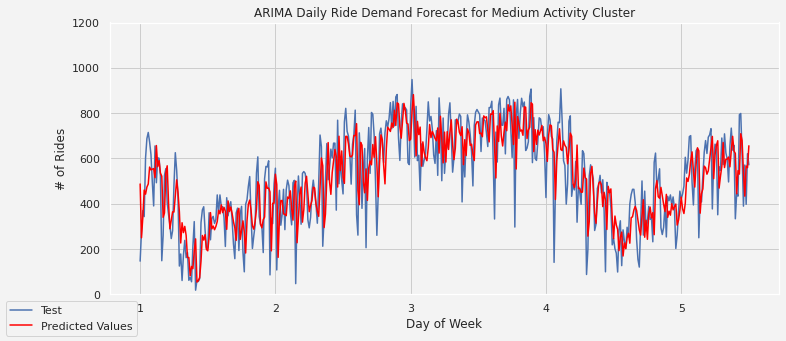

In [35]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(rider_demand_2.index)
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('# of Rides')
ax1.set_ylim(0,1200)
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Daily Ride Demand Forecast for Medium Activity Cluster')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

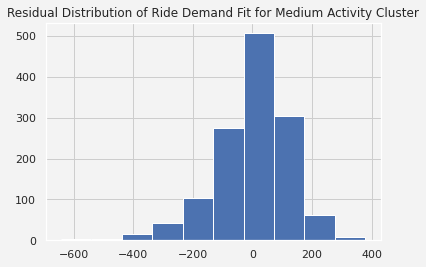

In [36]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
plt.hist(residuals)

plt.title('Residual Distribution of Ride Demand Fit for Medium Activity Cluster')
plt.show

In [37]:
true_cluster_2_fit, predictions, test, residuals = model_creation(true_rides_2)

Test RMSE: 138.316
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1324
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -8271.774
Date:                Sun, 20 Dec 2020   AIC                          16555.548
Time:                        19:41:35   BIC                          16586.673
Sample:                             0   HQIC                         16567.216
                               - 1324                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4735      0.025    -19.006      0.000      -0.522      -0.425
ar.L2         -0.4373      0.027    -16.445      0.000      -0.489      -0.385
ar.L3         -0.3931      0.028 

<ipython-input-38-1755b2079fd7>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(true_rides_2.index)


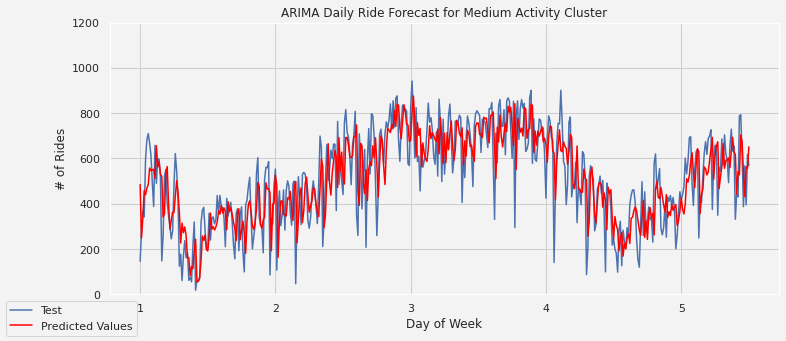

In [38]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(true_rides_2.index)
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('# of Rides')
ax1.set_ylim(0,1200)
plt.plot(test)
plt.plot(predictions, color='red')
fig.legend(['Test','Predicted Values'], loc=3)
plt.title('ARIMA Daily Ride Forecast for Medium Activity Cluster')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

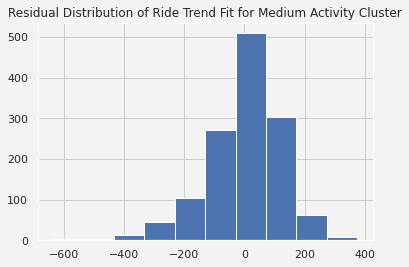

In [39]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
plt.hist(residuals)

plt.title('Residual Distribution of Ride Trend Fit for Medium Activity Cluster')
plt.show

<ipython-input-40-b85d83d8a288>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(true_rides_2.index)


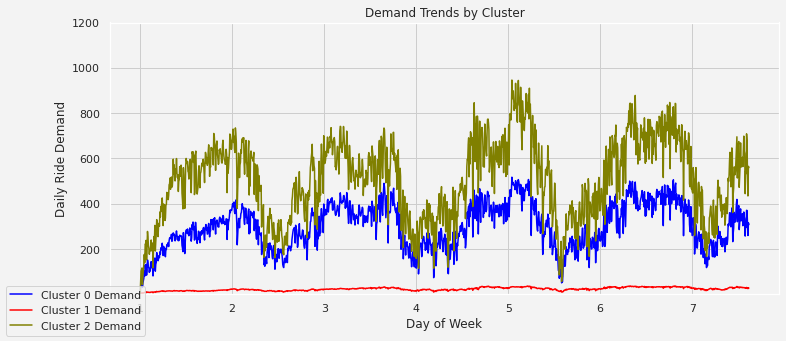

In [40]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(true_rides_2.index)
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Daily Ride Demand')
ax1.set_ylim(0,1200)
plt.plot(demand_fit.fittedvalues, color = 'blue')
plt.plot(demand_cluster_1_fit.fittedvalues, color='red')
plt.plot(demand_cluster_2_fit.fittedvalues, color='olive')
fig.legend(['Cluster 0 Demand','Cluster 1 Demand', 'Cluster 2 Demand'], loc=3)
plt.title('Demand Trends by Cluster')
plt.show()

<ipython-input-41-07edf0fe0ca8>:4: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(true_rides_2.index)


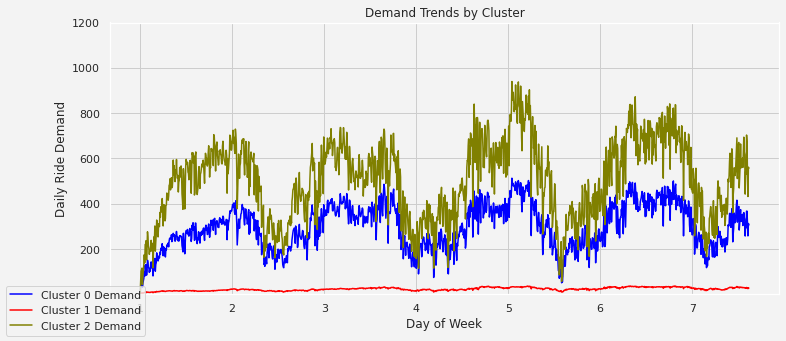

In [41]:
colors = ["#263571", '#ea2029', '#39a2e1']
sns.set(rc={'axes.facecolor':'#f3f3f3', 'figure.facecolor':'#f3f3f3', 'grid.color': '#cdcdcd'})
fig, ax1 = plt.subplots(figsize = (12,5))
ax1.set_xticklabels(true_rides_2.index)
ax1.set_xlabel('Day of Week')
ax1.set_ylabel('Daily Ride Demand')
ax1.set_ylim(0,1200)
plt.plot(real_demand_fit.fittedvalues, color = 'blue')
plt.plot(true_cluster_1_fit.fittedvalues, color='red')
plt.plot(true_cluster_2_fit.fittedvalues, color='olive')
fig.legend(['Cluster 0 Demand','Cluster 1 Demand', 'Cluster 2 Demand'], loc=3)
plt.title('Demand Trends by Cluster')
plt.show()